In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import glob
import numpy as np
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import warnings
warnings.filterwarnings('ignore')
from matplotlib.patches import Circle
from photutils.aperture import CircularAperture, ApertureStats, SkyCircularAperture
from matplotlib.gridspec import GridSpec
import os
import datetime as d
from xspec import *
from random import randint
#plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.family"] = "serif"

# astropy 5.2.2
# python 3.8
# photutils 1.8.0
# xspec

### Fonctions utilisées

In [31]:
def read_bat_catalog(source_name):
    catalog = fits.open("BAT_70m_catalog_20nov2012.fits")
    other_name = catalog[1].data["COUNTERPART_NAME"]
    source_idx = np.where(other_name == source_name)
    flux = catalog[1].data["FLUX"][source_idx] * 1e-12
    Gamma = catalog[1].data["GAMMA"][source_idx]
    return flux, Gamma

def read_arf(arf_filename):
    hdu1 = fits.open(arf_filename)
    arf_data=hdu1[1].data
    
    emin = arf_data.ENERG_LO
    emax = arf_data.ENERG_HI
    arf = arf_data.SPECRESP

    dE = emax - emin
    E = emin + (emax - emin) / 2

    return E, emin, emax, dE, arf
    
def powerlaw(x, norm, Gamma):
    return norm * x**(-Gamma)

def calculate_norm_from_flux(flux, Gamma, Emin, Emax):
    return flux * (-Gamma + 2) / (Emax**(-Gamma + 2) - Emin**(-Gamma + 2)) * 6.242e8

def calculate_countrate(n_H, Eband, norm, Gamma, model):
    
    E, emin, emax, dE, arf = read_arf("ECL-RSP-ARF_20220515T01.fits")

    if((Eband[0] <= E[0] - dE[0]) or (Eband[-1] >= E[-1] + dE[-1])):
        print("ERROR: energy band outside the arf energy range !")
    else:
        E_r = E[(E>=Eband[0]) & (E<=Eband[1])]
        dE_r = dE[(E>=Eband[0]) & (E<=Eband[1])]
        arf_r = arf[(E>=Eband[0]) & (E<=Eband[1])]
        emax_r = emax[(E>=Eband[0]) & (E<=Eband[1])]
        emin_r = emin[(E>=Eband[0]) & (E<=Eband[1])]
        
        a = 0.286733
        
        if(model == "powerlaw"):
            F = norm * E_r**(-Gamma) * np.exp(- n_H * a / E_r**3)
            #print("Absorbed flux = ", sum(norm * E_r**(-Gamma) * np.exp(- n_H * a / E_r**3) * dE_r) / 6.242e8, "erg/s/cm2")
            countrate = sum(arf_r * norm * E_r**(-Gamma) * np.exp(- n_H * a / E_r**3) * dE_r)
            
        elif(model == "cutoffpl"):
            F = norm * E_r**(-Gamma) * np.exp(-E_r / E_cut) * np.exp(- n_H * a / E_r**3)
            countrate = sum(arf_r * norm * E_r**(-Gamma) * np.exp(-E_r / E_cut) * np.exp(- n_H * a / E_r**3) * dE_r)
        
        elif(model == "bbody"):
            F = norm * 8.0525 * E_r**2 / (kT**4 * (np.exp(E_r/kT) - 1)) * np.exp(- n_H * a / E_r**3)
            countrate = sum(arf_r * norm * 8.0525 * E_r**2 / (kT**4 * (np.exp(E_r/kT) - 1)) * np.exp(- n_H * a / E_r**3) * dE_r)
            
        flux_simu = countrate / sum(arf_r * dE_r)
        #print("\033[90mRough expected flux:", f'{countrate / (1024 * 0.4):.3f}', "cts/s/cm2")
        print("\033[90mRough expected countrate:", f'{countrate:.3f}', "cts/s")
        print("\033[90mRough expected countrate in the simulator:", f'{countrate:.3f}', '* 1.37 =', 
              f'{countrate*1.37:.3f}', "cts/s")
        #print("\033[90mRough expected countrate in the simulator:", f'{countrate:.3f}', '* 1.37 =', 
        #      f'{countrate*1.37:.3f}', "cts/s")
    return countrate, flux_simu
    
def read_det_file(filename, type_, save):
    fitsfile = fits.open(filename[0])
    nrows = int((len(fitsfile) - 2) / 3)
    fig1, ax1 = plt.subplots(ncols = 3, nrows = nrows, figsize = (15, nrows * 5))
    fig2, ax2 = plt.subplots(ncols = 3, nrows = nrows, figsize = (15, nrows * 5))
    for i in range(nrows):
        for j in range(3):
            image = fitsfile[j+2+3*i].data
            title = fitsfile[j+2+3*i].header["IMATYPE"] + "-" + EO + "\n"
            title += "E = " + str(fitsfile[j+2+3*i].header["E_MIN"]) + "-"
            title += str(fitsfile[j+2+3*i].header["E_MAX"]) + " keV"
            if(nrows > 1):
                ax1[i][j].set_title(title)
                ax1[i][j].set_xlabel("Pixels")
                ax1[i][j].set_ylabel("Pixels")
                pos = ax1[i][j].imshow(image, cmap = "viridis")
                fig1.colorbar(pos, ax = ax1[i][j], shrink = 0.7)
                image_flat = image.flatten()
                good = np.where(image_flat != 0)
                ax2[i][j].hist(image_flat[good], bins = 60, histtype = "step", color = "black")
                ax2[i][j].set_title(title)
                ax2[i][j].set_xlabel("Counts")
                ax2[i][j].set_ylabel("Number")
            else:
                ax1[j].set_title(title)
                ax1[j].set_xlabel("Pixels")
                ax1[j].set_ylabel("Pixels")
                pos = ax1[j].imshow(image, cmap = "viridis")
                fig1.colorbar(pos, ax = ax1[j], shrink = 0.7)
                image_flat = image.flatten()
                good = np.where(image_flat != 0)
                ax2[j].hist(image_flat[good], bins = 60, histtype = "step", color = "black")
                ax2[j].set_title(title)
                ax2[j].set_xlabel("Counts")
                ax2[j].set_ylabel("Number")
    plt.subplots_adjust(hspace = 0.4)
    #print(output_directory + "/det_var_" + type_ + "_images.pdf")
    if(save == 1):
        fig1.savefig(output_directory + "/det_" + type_ + "_images_" + EO + ".pdf", bbox_inches = "tight")
        fig2.savefig(output_directory + "/det_" + type_ + "_distrib_" + EO + ".pdf", bbox_inches = "tight")
            
def check_det_var(save = 0):
    det_ima = glob.glob(directory + "/ECL-DET-IMA-" + EO + '*')
    det_ubc = glob.glob(directory + "/ECL-DET-UBC-" + EO + '*')
    
    fits_det_ima = fits.open(det_ima[0])
    fits_det_ubc = fits.open(det_ima[0])
    nrows_det_ima = int((len(fits_det_ima) - 2) / 3)
    nrows_det_ubc = int((len(fits_det_ubc) - 2) / 3)
    
    print("Evaluating DET-IMA and DET-VAR for", nrows_det_ima, "energy bins...")
    for i in range(nrows_det_ima):
        if (np.array_equal(fits_det_ima[2+i*3].data, fits_det_ima[3+i*3].data)):
            print("\033[92m DET-IMA and DET-VAR are equal for",
            fits_det_ima[2+i*3].header["E_MIN"], "and", fits_det_ima[2+i*3].header["E_MAX"])
        else:
            print("\033[91m DET-IMA et DET-VAR are NOT equal for",
            fits_det_ima[2+i*3].header["E_MIN"], "and", fits_det_ima[2+i*3].header["E_MAX"])
            
    print("\033[90mEvaluating DET-IMA-VAR and DET-UBC-VAR for", nrows_det_ima, "energy bins...")
    for i in range(nrows_det_ubc):
        if (np.array_equal(fits_det_ima[3+i*3].data, fits_det_ubc[3+i*3].data)):
            print("\033[92m DET-IMA-VAR and DET-UBC-VAR are equal for",
            fits_det_ima[2+i*3].header["E_MIN"], "and", fits_det_ima[2+i*3].header["E_MAX"])
        else:
            print("\033[91m DET-IMA-VAR and DET-UBC-VAR are NOT equal for",
            fits_det_ima[2+i*3].header["E_MIN"], "and", fits_det_ima[2+i*3].header["E_MAX"])
    print('\n')
    print("\033[90mECL-DET-IMA")
    read_det_file(det_ima, "ima", save)
    plt.show()
    print("ECL-DET-UBC")
    read_det_file(det_ubc, "ubc", save)
    plt.show()

def check_sky_file(save = 0):
    filename = glob.glob(directory + "/ECL-SKY-IMA-" + EO + '*')
    sop_filename = glob.glob(directory + "/ECL-SOP-IMA-" + EO + '*')
    ima_file = fits.open(filename[0])
    sop_file = fits.open(sop_filename[0])
    nrows = int((len(ima_file) - 2) / 5)
    ncols = 5
    fig = plt.figure(figsize = (25, nrows * 5))
    for i in range(nrows):
        sources = sop_file[2+i].data["OBJECTID"]
        sources_ra = sop_file[2+i].data["RA_FIN"]
        sources_dec = sop_file[2+i].data["DEC_FIN"]
        sop_wcs = WCS(sop_file[2+i].header)
        all_sources = []

        for j in range(ncols * nrows):
            wcs = WCS(ima_file[j+2].header)
            image = ima_file[j+2].data
            ax = plt.subplot(nrows, ncols, j+1, projection = wcs, label = "overlays")
            ax.coords[0].set_axislabel('Right Ascension (J2000)')
            ax.coords[1].set_axislabel('Declination (J2000)')
            title = ima_file[j+2].header["IMATYPE"] + "-" + EO + "\n"
            title += "E = " + str(ima_file[j+2].header["E_MIN"]) + "-"
            title += str(ima_file[j+2].header["E_MAX"]) + " keV\n\n"
            if(ima_file[j+2].header["IMATYPE"] == "SIGNIFICANCE"):
                    #pos = ax.imshow(image, cmap = "hot", vmin = 0.15 * np.nanmax(image), vmax = np.nanmax(image))
                pos = ax.imshow(image, cmap = "viridis", vmin = 5, vmax = 10) #!!!!!
            else:
                pos = ax.imshow(image, cmap = "viridis", vmin = 0, vmax = np.nanmax(image))
            fig.colorbar(pos, ax = ax, shrink = 0.7)
            ax.set_title(title)
    plt.subplots_adjust(wspace = 0.3, hspace = 0.2)
    if(save == 1):
        fig.savefig(output_directory + "/sky_ima_" + EO + ".pdf", bbox_inches = "tight")
    
def check_peak_flux(threshold, save = 0):
    filename = glob.glob(directory + "/ECL-SKY-IMA-" + EO + '*')
    sop_filename = glob.glob(directory + "/ECL-SOP-IMA-" + EO + '*')
    ima_file = fits.open(filename[0])
    sop_file = fits.open(sop_filename[0])
    n = int((len(ima_file) - 2) / 5)
    for i in range(n):
        wcs = WCS(ima_file[2+2+5*i].header)
        image = ima_file[2+2+5*i].data
        title = ima_file[2+2+5*i].header["IMATYPE"] + "-" + EO + "\n"
        title += "E = " + str(ima_file[2+2+5*i].header["E_MIN"]) + "-"
        title += str(ima_file[2+2+5*i].header["E_MAX"]) + " keV\n\n"

        fig = plt.figure(figsize = (7, 7))
        ax = plt.subplot(1, 1, 1, label = "overlays", projection = wcs)
        ax.coords[0].set_axislabel('Right Ascension (J2000)')
        ax.coords[1].set_axislabel('Declination (J2000)')
        pos = ax.imshow(image, cmap = "viridis", vmin = 5, vmax = 10)
        fig.colorbar(pos, ax = ax, shrink = 0.7)
        ax.set_title(title)
        
        emin = ima_file[2+2+5*i].header["E_MIN"]
        emax = ima_file[2+2+5*i].header["E_MAX"]
        
        sources = sop_file[2+i].data["OBJECTID"]
        sources_ra = sop_file[2+i].data["RA_FIN"]
        sources_dec = sop_file[2+i].data["DEC_FIN"]
        sop_wcs = WCS(sop_file[2+i].header)
        sop_fluxes = sop_file[2+i].data["FLUX"]
        sop_fluxes_err = sop_file[2+i].data["FLUX_ERR"] 
        sop_detsig = sop_file[2+i].data["RAWSNR"] 
        sop_y_peak = sop_file[2+i].data["Y_PEAK"]
        sop_z_peak = sop_file[2+i].data["Z_PEAK"]
        #mean, median, std = sigma_clipped_stats(ima_file[2+i*5].data, sigma=3.0)  
        #daofind = DAOStarFinder(fwhm = 3.0, threshold = 5. * std)
        #print(daofind)
        #sources_detected = daofind(ima_file[2+i*5].data - median)
        #print(sources_detected)    
        #print("SOP-IMA fluxes:")
        print(len(sources), "sources detected in the " + str(ima_file[2+2+5*i].header["E_MIN"]) + "-" +
        str(ima_file[2+2+5*i].header["E_MAX"]) + " keV energy range")
        
        for k in range(len(sources)):
            c = Circle((sources_ra[k], sources_dec[k]), 3, edgecolor = "yellow",
                    transform = ax.get_transform('fk5'),
                    facecolor = "none")
            
            ax.annotate(sources[k], xy = (sources_ra[k], sources_dec[k]), 
                        xytext = (sources_ra[k], sources_dec[k]),
                        xycoords = ax.get_transform('fk5'), color = "yellow")
            ax.add_patch(c)
            
            position = SkyCoord(sources_ra[k], sources_dec[k], unit='deg', frame='icrs')
            aperture = SkyCircularAperture(position, r=150.0 * u.arcmin)
            pix_aperture = aperture.to_pixel(wcs)
            aperstats = ApertureStats(ima_file[2+i*5].data, pix_aperture)
            print("\033[90m----------", sources[k], "----------")
            

            flux, Gamma = read_bat_catalog(sources[k])
            if(sources[k] == "4C +27.14"):
                flux, Gamma = read_bat_catalog("Cen A")
                
            if(sop_detsig[k] > threshold):
                print("\033[92m", sources[k], "has a raw SNR = ", sop_detsig[k], ">", threshold)
            else:
                print("\033[91m", sources[k], "has a raw SNR = ", sop_detsig[k], "<", threshold)
            calc_costheta(sop_y_peak[k], sop_z_peak[k])
            
            if(len(flux) != 0):
                print("\033[90mFlux  =", flux[0], "ergs/cm2/s (14-195 keV)")
                print("\033[90mGamma =", Gamma[0])
                norm = calculate_norm_from_flux(flux, Gamma, 14, 195)
                countrate, flux_simu = calculate_countrate(0, [emin, emax], norm, Gamma, "powerlaw")
                print("\033[90mFlux value in SOP-IMA:", f'{sop_fluxes[k]:.4f}', "+/-", 
                      f'{sop_fluxes_err[k]:.4f}', "\033[93mcts/s/cm2 \033[90m; Countrate:", 
                      f'{sop_fluxes[k] * 1296 * 0.4:.3f}', "+/-", 
                      #f'{sop_fluxes[k]:.3f}', "+/-", 
                      f'{sop_fluxes_err[k] * 1296 * 0.4:.3f}', "cts/s")
                print("\033[90mPeak value in SKY-IMA:", 
                      f'{aperstats.max:.4f}', "\033[93mcts/s/cm2 \033[90m; Countrate:",
                      f'{aperstats.max * 1296 * 0.4:.3f}', "cts/s")
            
                #diff = countrate/(1296*0.4)+countrate/(1296*0.4)*0.10 - countrate/(1296*0.4)
                #diff = countrate/(1024*0.4)+countrate/(1024*0.4) - countrate/(1024*0.4)
                diff = countrate + countrate * 0.10 - countrate
            
                #if(countrate/(1024*0.4) > np.abs(countrate/(1024*0.4) - (sop_fluxes[k] + sop_fluxes_err[k]))):

                if((sop_fluxes[k] - sop_fluxes_err[k])*1296*0.4 <= countrate*1.37 <= (sop_fluxes[k] + sop_fluxes_err[k]) * 1296 * 0.4):
                    print("\033[92mFlux in SOP-IMA consistent with expected flux in the simulator")
                else:
                    print("\033[91mFlux in SOP-IMA NOT consistent with expected flux in the simulator")
                #if(np.abs(diff) > np.abs(countrate*1.37/(1296*0.4) - aperstats.max)):
                #    print("\033[92mFlux in SKY-IMA consistent with expected flux in the simulator")
                #else:
                #    print("\033[91mPeak flux in SKY-IMA NOT consistent with expected flux in the simulator")
                    
            else:
                print("\033[91m", sources[k], "not found in the catalog")
            
        
        plt.show()
        if(save == 1):
            fig.savefig(output_directory + "/sky_ima_sig_" + str(emin) + "-" + str(emax) + "_" + EO + ".pdf",
                    bbox_inches = "tight")
            
def check_offset_vs_snr(save = 0):
    markers = ["P", "v", "s", "*", "D", "x", "d", "<", ">", "X", "x", "^", "8", "H", "h"]
    sop_filename = glob.glob(directory + "/ECL-SOP-IMA-" + EO + '*')
    sop_file = fits.open(sop_filename[0])
    nbands = len(sop_file) - 2
    all_sources = []
    all_offset_pix = []
    all_offset_min = []
    all_bands = []
    all_raw_snr = []
    all_yz_err = []
    labels = []
    for i in range(nbands):
        sources = sop_file[2+i].data["OBJECTID"]
        raw_snr = sop_file[2+i].data["RAWSNR"]
        ra_fin = sop_file[2+i].data["RA_FIN"]
        dec_fin = sop_file[2+i].data["DEC_FIN"]
        ra_obj = sop_file[2+i].data["RA_OBJ"]
        dec_obj = sop_file[2+i].data["DEC_OBJ"]
        y_obj = sop_file[2+i].data["Y_OBJ"]
        y_fin = sop_file[2+i].data["Y_FIN"]
        z_obj = sop_file[2+i].data["Z_OBJ"]
        z_fin = sop_file[2+i].data["Z_FIN"]
        yz_err_fin = sop_file[2+i].data["YZ_ERR"]

        emin = sop_file[2+i].header["E_MIN"]
        emax = sop_file[2+i].header["E_MAX"]
        labels.append(str(emin) + "-" + str(emax))

        dy_pix = np.abs(y_obj - y_fin)
        dz_pix = np.abs(z_obj - z_fin)
        offset_pix = np.sqrt(dy_pix**2 + dz_pix**2)

        ra_obj = np.abs(ra_obj - ra_fin)
        dec_obj = np.abs(dec_obj - dec_fin)
        offset_min = np.sqrt(ra_obj**2 + dec_obj**2) * 60

        for j in range(len(sources)):
            all_sources.append(sources[j])
            all_offset_pix.append(offset_pix[j])
            all_offset_min.append(offset_min[j])
            all_raw_snr.append(raw_snr[j])
            all_yz_err.append(yz_err_fin[j])
            all_bands.append(i)

    # Figure
    fig, ax = plt.subplots(figsize = (7, 9), nrows = 2, ncols = 1, sharex = True)

    k_pix = 2.74
    k_min = 80.92
    snr = np.arange(0, 1000)
    ax[0].plot(snr, k_pix / snr, color = "black", linewidth = 2)
    ax[1].plot(snr, k_min / snr, color = "black", linewidth = 2)

    known_sources_info = []
    known_sources_names = []
    unknown_sources_info = []
    for i in range(len(all_sources)):
        if(all_sources[i][0:7] == "unknown"):
            #ax[0].scatter(all_raw_snr[i], all_offset_pix[i], color = "black",#, label = labels[i],
            #              facecolor = 'None')
            unknown_sources_info.append([all_sources[i], all_offset_pix[i],
            all_offset_min[i], all_yz_err[i], all_raw_snr[i], all_bands[i]])
        else:
            known_sources_info.append([all_sources[i], all_offset_pix[i],
            all_offset_min[i], all_yz_err[i], all_raw_snr[i], all_bands[i]])
            known_sources_names.append(all_sources[i])
    known_sources_names = np.unique(known_sources_names)

    colors = []
    n = len(known_sources_names)
    for i in range(n):
        colors.append('#%06X' % randint(0, 0xFFFFFF))

    for i in range(len(known_sources_names)):
        ax[0].scatter(0, 0, label = known_sources_names[i], color = colors[i])
        ax[0].legend(loc = "lower left", bbox_to_anchor = (1, 0))
        for j in range(np.shape(known_sources_info)[0]):
            if(known_sources_names[i] == known_sources_info[j][0]):
                for k in range(nbands):
                    if(known_sources_info[j][-1] == k):
                        ax[0].scatter(known_sources_info[j][4], known_sources_info[j][1],
                                color = colors[i], marker = markers[k],
                                facecolor = 'None')
                        ax[1].scatter(known_sources_info[j][4], known_sources_info[j][2],
                                color = colors[i], marker = markers[k],
                                facecolor = 'None')

    for i in range(np.shape(unknown_sources_info)[0]):
        for k in range(nbands):
            if(unknown_sources_info[j][-1] == k):
                ax[0].scatter(unknown_sources_info[i][4], unknown_sources_info[i][1], color = "black", marker = markers[k], facecolor = 'None')
                ax[1].scatter(unknown_sources_info[i][4], unknown_sources_info[i][2], color = "black", marker = markers[k], facecolor = 'None')
    if(nbands > 1):
        for i in range(len(known_sources_names)):
            ax[1].scatter(0, 0, marker = markers[i], color = "black", facecolor = "None", label = labels[i] + " keV")
    else:
        ax[1].scatter(0, 0, marker = markers[0], color = "black", facecolor = "None", label = labels[0] + " keV")
    #    for i in range(len(known_sources_names)):
    #        

    ax[1].legend(loc = "upper left", bbox_to_anchor = (1, 1))

    for axarr in ax:
        axarr.set_xscale("log")
        axarr.set_yscale("log")
        axarr.grid(linestyle = ":")
    ax[1].set_xlabel("Raw SNR")
    ax[0].set_ylabel("Pixel Offset (pix)")
    ax[1].set_ylabel("Pixel Offset (min)")
    ax[0].set_xlim(1, 1000)

    plt.subplots_adjust(hspace = 0.1)
    if(save == 1):
        fig.savefig(output_directory + "/offset_vs_snr_" + EO + ".pdf", bbox_inches = "tight")
    #plt.show()
    
def read_EAR_OFM(save = 0):
    fig = plt.figure(figsize = (7, 7))
    fits_filename = glob.glob(directory + "/ECL-EAR-OFM-" + EO + "*.fits")
    print(fits_filename)
    fitsfile = fits.open(fits_filename[0])
    image = fitsfile[1].data
    title = "Pixel fraction covered by Earth - " + EO
    plt.xlabel("Pixels")
    plt.ylabel("Pixels")
    plt.title(title)
    pos = plt.imshow(image, cmap = "viridis")
    fig.colorbar(pos, shrink = 0.8)
    if(save == 1):
        fig.savefig(output_directory + "/ofm_map_" + EO + ".pdf", bbox_inches = "tight")
    
def plot_unknown_positions(save = 0):
    sop_filename = glob.glob(directory + "/ECL-SOP-IMA-" + EO + '*')
    sop_file = fits.open(sop_filename[0])
    colors = []
    labels = []
    n = len(sop_file) - 2
    for i in range(n):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
        emin = sop_file[2+i].header["E_MIN"]
        emax = sop_file[2+i].header["E_MAX"]
        labels.append(str(emin) + "-" + str(emax))

    fig = plt.figure(figsize = (5, 5))
    for i in range(len(sop_file) - 2):
        sources = sop_file[2+i].data["OBJECTID"]
        ra_fin = sop_file[2+i].data["RA_FIN"]
        dec_fin = sop_file[2+i].data["DEC_FIN"]
        plt.scatter(ra_fin[0], dec_fin[0], color = colors[i], label = labels[i] + " keV", alpha = 0.7)
        for j in range(len(sources)):
            if(sources[j][0:7] == "unknown"):
                plt.scatter(ra_fin[j], dec_fin[j], color = colors[i], alpha = 0.7) 
        
    plt.xlabel("ra (°)")
    plt.ylabel("dec (°)")
    plt.legend(loc = "upper left", bbox_to_anchor = (1, 1))
    plt.show()
    if(save == 1):
        fig.savefig(output_directory + "/unknown_pos_" + EO + ".pdf", bbox_inches = "tight")
    
def read_sps(source_name):
    sps_filename = glob.glob(directory + "/*SPS*" + EO + "*")
    print(directory + "/*SPS*" + EO + "*")
    print(sps_filename)
    fitsfile = fits.open(sps_filename[0])
    spectrum = fitsfile["ECLSPEC_" + source_name].data
    channels = spectrum["CHANNEL"]
    rate     = spectrum["RATE"] / 1.37 #* 1296 * 0.4
    stat_err = spectrum["STAT_ERR"] #/ 1.37 #* 1296 * 0.4
    sys_err  = spectrum["SYS_ERR"] #+ 0.03
    quality  = spectrum["QUALITY"]
    grouping = spectrum["GROUPING"]
    exposure = fitsfile["ECLSPEC_" + source_name].header['EXPOSURE']
    return channels, rate, stat_err, sys_err, quality, grouping, exposure

def create_binfile(output_directory, chan_list, source_name):
    binfile_name = output_directory + "/binfile_" + source_name.replace(" ", "_") + "_" + EO + ".txt"
    binfile = open(binfile_name, "w")
    binfile.write("1 " + str(chan_list[0][0] - 1) + " -1\n")
    for i in range(len(chan_list)):
        binfile.write(str(chan_list[i][0]) + " " + str(chan_list[i][1]) + " "
                    + str(chan_list[i][1] - chan_list[i][0] + 1) + "\n")
    binfile.write(str(chan_list[i][1] + 1) + " 1430 -1\n")
    #binfile.write(str(chan_list[i][1] + 1) + " 201 -1\n")
    binfile.close()
    return binfile_name

def create_rbnrmf(source_name):
    sop_filename = glob.glob(directory + "/*SOP*" + EO + "*")
    fitsfile = fits.open(sop_filename[0])
    nb_ext = len(fitsfile)
    chan_list = []
    for i in range(2, nb_ext):
        chan_min = int(fitsfile[i].name[7:11])
        chan_max = int(fitsfile[i].name[12:17])
        if(source_name in fitsfile[i].data["OBJECTID"]):
            chan_list.append([chan_min, chan_max])

    binfile_name = create_binfile(output_directory, chan_list, source_name)
    #rbnrmf_cmd  = "rbnrmf infile=ECL-RSP-RMF_20220515T01.fits "
    rbnrmf_cmd  = "rbnrmf infile=test_diag_rmf.fits "
    rbnrmf_cmd += "binfile=" + binfile_name + " " + " outfile=" 
    rbnrmf_cmd += output_directory + "/" + source_name.replace(" ", "_") + "_" + EO + "_rmf.fits clobber=yes"
    
    #print(rbnrmf_cmd)  
    os.system(rbnrmf_cmd)
    
def check_sps_positions():
    sps_filename = glob.glob(directory + "/*SPS*" + EO + "*")
    fitsfile = fits.open(sps_filename[0])

    for i in range(2, len(fitsfile) - 2):
        source_name = fitsfile[i].name[8:]
        if(source_name[0:7] != "unknown"):
            print("\033[90m-----", source_name, "-----")
            ra_obj = fitsfile[i].header["RA_OBJ"]
            dec_obj = fitsfile[i].header["DEC_OBJ"]
            
            ra_pos = fitsfile[i].header["RA_POS"]
            dec_pos = fitsfile[i].header["DEC_POS"]
            if (ra_pos == ra_obj) and (dec_pos == dec_obj):
                print("\033[92m RA_OBJ = RA_POS = ", ra_pos)
                print("\033[92m DEC_OBJ = DEC_POS = ", dec_pos)
            else:
                print("\033[91m RA_OBJ =", ra_obj, "!= RA_POS =", ra_pos)
                print("\033[91m DEC_OBJ =", dec_obj, "!= DEC_POS =", dec_pos)
                
def convert2pha(source_name):
    channels, rate, stat_err, sys_err, quality, grouping, exposure = read_sps(source_name)
    #sys_err = np.ones(len(channels)) * 0.02
    grouping = np.ones(len(channels))
    
    channels = np.arange(len(channels))
    # Create the primary header
    t = str(d.datetime.now())
    PrimeHeader=fits.Header()
    PrimeHeader['DATE'] = t[:10]
    PrimeHeader['TELESCOP'] ='SVOM'
    PrimeHeader['INSTRUME'] = 'ECL'
    PrimeHeader['CONTENT']  = 'SPECTRUM'
    PrimeHeader['PHAVERSN'] = '1992a'
    PrimeHDU= fits.PrimaryHDU(header = PrimeHeader)

    # Create the secondary header
    SecHeader = fits.Header()
    SecHeader['DATE'] = t[:10]
    SecHeader['TELESCOP'] = 'SVOM'
    SecHeader['INSTRUME'] = 'ECL'
    SecHeader['CONTENT']  = 'SPECTRUM'
    SecHeader['PHAVERSN'] = '1992a'
    SecHeader['EXPOSURE'] = float(exposure) #float(3151.0) # A modifier pour que ça aille chercher le temps d'expo dans le fichier
    SecHeader['AREASCAL'] = float(1.0)#float(352.)
    SecHeader['BACKSCAL'] = float(1.0)
    SecHeader['CORRSCAL'] = float(0.0)
    SecHeader['BACKFILE'] = 'NONE'
    SecHeader['CORRFILE'] = 'NONE'
    SecHeader['RESPFILE'] = output_directory + "/" + source_name.replace(" ", "_") + "_" + EO + "_rmf.fits"
    SecHeader['ANCRFILE'] = "ECL-RSP-ARF_20220515T01.fits"
    SecHeader['POISSERR'] = False
    SecHeader['CHANTYPE'] ='PI'
    SecHeader['DETCHANS'] = (len(channels))
    SecHeader['SYS_ERR']  = 0
    SecHeader['QUALITY']  = 0
    SecHeader['GROUPING'] = 0

    #arf = np.array([36, 75, 158, 304, 302])
    #arf = np.array([1611, 3343, 6971, 13385, 13292])
    #energy = np.array([6, 10, 20, 40, 80])
    col1 = fits.Column(name = 'CHANNEL', format = '1J', array = channels)
    #col2 = fits.Column(name = 'COUNTS', format = '1E', array = rate * 3151.0, unit = "cts")
    col2 = fits.Column(name = 'RATE', format = '1E', array = rate, unit = "counts/s")
    col3 = fits.Column(name = 'STAT_ERR', format = '1E', array = stat_err, unit = "counts/s")
    col4 = fits.Column(name = 'SYS_ERR', format = '1E', array = sys_err)
    col5 = fits.Column(name = 'QUALITY', format = '1I', array = quality)
    col6 = fits.Column(name = 'GROUPING', format = '1I', array = grouping)

    cols = fits.ColDefs([col1, col2, col3, col4, col5, col6])
    tabledata=fits.BinTableHDU.from_columns(cols,header=SecHeader,name='SPECTRUM')
    thdulist=fits.HDUList([PrimeHDU,tabledata])
    thdulist.writeto(output_directory + "/" + source_name.replace(" ", "_") + "_" + EO + ".pha",overwrite = True)
    print(output_directory + "/" + source_name.replace(" ", "_") + "_" + EO + ".pha has been created!")
    
def check_empty_kw():
    #print(output_directory + "/empty_keywords/")
    if not os.path.isdir(output_directory + "/empty_keywords/"):
        os.system("mkdir " + output_directory + "/empty_keywords/")
    filenames = glob.glob(directory + "/*.fits")
    for filename in filenames:
        file = open(output_directory + "/empty_keywords/" + filename[len(directory):-5] + ".kw", "w")
        fitsfile = fits.open(filename)
        for i in range(len(fitsfile)):
            count = 0
            print("------------- HDU ", i , "-------------")
            file.write("-------- HDU " + str(i) + "--------\n")
            hdu = fitsfile[1].header
            kw = list(hdu.keys())
            for j in range(len(kw)):
                if hdu[kw[j]] == '':
                    print(kw[j], "is missing")
                    file.write(kw[j] + " is missing\n")
                elif hdu[kw[j]] == None:
                    print(kw[j], "\t ----------> is empty")
                    file.write(kw[j] + "\n")
                    count += 1
            print("Empty keywords :", count)
            file.write("Empty keywords : " + str(count) + "\n")
    file.close()
    
def fit_with_xspec(source_name, save = 0):
    #source_name = source_name.replace(" ", "_")
    
    #if not os.path.isfile(output_directory + "/" + source_name.replace(" ", "_") + "_" + EO + ".pha"):
    convert2pha(source_name)
    #if not os.path.isfile(output_directory + "/" + source_name.replace(" ", "_") + "_" + EO + "_rmf.fits"):
    create_rbnrmf(source_name)
        
    #s1 = Spectrum(output_directory + "/" + source_name.replace(" ", "_") + ".pha")
    #print(source_name)
    #print(output_directory + "/" + source_name.replace(" ", "_"))
    #print("1:1 " + output_directory + "/" + source_name.replace(" ", "_") + ".pha")
    AllData("1:1 " + output_directory + "/" + source_name.replace(" ", "_") + "_" + EO + ".pha")
    #AllData("resp " + output_directory + "/" + source_name.replace(" ", "_") + "_rmf.fits")
    model = Model("powerlaw")
    Fit.perform()
    Fit.error("max 5")
    Fit.error("1-2")
    Plot("euf")
    Plot.xAxis = "keV"
    
    energies = np.asarray(Plot.x())
    fluxes  = np.asarray(Plot.y())
    energies_err = np.asarray(Plot.xErr())
    fluxes_err  = np.asarray(Plot.yErr())
    folded = Plot.model()
    
    Plot("delchi")
    Plot.xAxis = "keV"
    energies_delchi = np.asarray(Plot.x())
    delchi  = np.asarray(Plot.y())
    energies_delchi_err = np.asarray(Plot.xErr())
    delchi_err  = np.asarray(Plot.yErr())
    
    a = 0.286733
    fig = plt.figure(figsize = (7, 5))
    gs  = GridSpec(2, 1, width_ratios = [1], height_ratios = [4, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax1.errorbar(energies, fluxes, xerr = energies_err, yerr = fluxes_err, fmt = ".", color = "black", capsize = 2)
    ax1.plot(energies, folded, color = "red", linewidth = 3, alpha = 0.7, label = "Best fit")
    
    flux, Gamma = read_bat_catalog(source_name.replace("_", " "))
    print("----- BAT catalog -----")
    print("flux =", flux, "ergs/cm$^2$/s")
    print("Gamma =", Gamma)
    #print("In BAT catalog : flux = ", flux )
    #print(flux, Gamma)
    if(source_name.replace("_", " ") == "4C +27.14"):
        flux, Gamma = read_bat_catalog("Cen A")
    norm = calculate_norm_from_flux(flux, Gamma, 15, 195)
    print("Norm =", norm, "ph/cm$^2$/s/keV")
    F = norm * energies**(-Gamma) * np.exp(- 0 * a / energies**3)
    ax1.plot(energies, F*energies, color = "blue", label = "Expected " + source_name)
    
    ax2.errorbar(energies_delchi, delchi, xerr = energies_delchi_err, yerr = delchi_err, fmt = ".", color = "black", capsize = 2)
    
    ax2.axhline(y = 0, color = 'grey', linestyle = ':')
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax2.set_xscale("log")
    ax2.set_xlabel("Energy [keV]")
    ax1.set_ylabel("keV [ph/cm$^2$/s/keV]")
    ax2.set_ylabel("(data - model)/error")
    ax1.set_xticks([])
    ax1.legend()
    if(save == 1):
        fig.savefig(output_directory + "/spec_fit_" + source_name + "_" + EO + ".pdf", bbox_inches = "tight")

def calc_costheta(xpix, ypix):
    h = 45.77    # counter from the detector top to the half mask plane
    pix = 0.45   # pixel geom size
    ph = pix / h
    dim = 199    # FOV size
    ic = 199 / 2 # central FOV pix
    cos_theta = np.zeros([dim, dim])
    
    for i in range(0, dim):
        dx = int(i - ic) 
        #print(dx)
        for j in range(0, dim):
            dy = int(j - ic) 
            
            rh = np.sqrt(dx**2 + dy**2) * ph
            theta = np.arctan(rh)
            
            cos_theta[i][j] = np.cos(theta)
    #print(cos_theta)
    #plt.imshow(cos_theta)
    print("\033[90mcos(theta) should be " f'{cos_theta[int(xpix + ic)][int(ypix + ic)]:.3f}' " at (y_peak, z_peak) position (" f'{xpix}' "," f'{ypix}'")")
    
def read_mask():
    maskfile = fits.open("C3A2S_CODEDMASK_UGTS_v3_47.fits")
    mask = maskfile[0].data
    cadran0 = np.fliplr(mask[0:23,0:23])
    cadran1 = np.fliplr(mask[0:23, 24:47])
    cadran2 = np.fliplr(mask[24:47, 24:47])
    cadran3 = np.fliplr(mask[24:47, 0:23])
    
    return mask, cadran0, cadran1, cadran2, cadran3

# IDL
#cadran0 = mask(24:46,0:22)
#cadran1 = mask(0:22,0:22)
#cadran2 = mask(0:22,24:46)
#cadran3 = mask(24:46,24:46)
def inmask(i, j, ndim):
    if(i < 0) or (i >= ndim) or (j < 0) or (j >= ndim):
        val = 0
    else:
        val = 1
    return val

def calc_det_pixel_illum(mask_elem_mm, x10, x20, y10, y20, ndim, mask): # oblicz_mask_val_dz
    x1 = x10 / mask_elem_mm 
    x2 = x20 / mask_elem_mm
    
    y1 = y10 / mask_elem_mm
    y2 = y20 / mask_elem_mm
    
    i1 = int(np.floor(x1))
    i2 = int(np.floor(x2))
    j1 = int(np.floor(y1))
    j2 = int(np.floor(y2))
    
    if(i1 == i2):
        if(j1 == j2):
            typ = 0 
        else:
            typ = 2
    else:
        if(j1 == j2):
            typ = 1 
        else:
            typ = 3     
    norma = (x2 - x1) * (y2 - y1)
    
    # typ
    # 0 in one mask pixel
    # 1 vertical cross
    # 2 horizonthal cross
    # 3 in 4 mask pixels
    val_left_up = 0
    val_right_up = 0
    val_left_low = 0
    val_right_low = 0
    
    det_pixel_illum = 0
    if(typ == 0): ### ligne 383
        if inmask(i1, j1, ndim):
            det_pixel_illum = mask[j1][i1]
            
    elif(typ == 1):
        val_left = 0
        if inmask(i1, j1, ndim):
            val_left = mask[j1][i1]
        val_right = 0    
        if inmask(i2, j1, ndim):
            val_right = mask[j1][i2]       
        det_pixel_illum = (val_left * (i2 - x1) + val_right * (x2 - i2)) / (y2 - y1)
        
    elif(typ == 2):
        val_low = 0 
        if inmask(i1,j1,ndim):
            val_low = mask[j1][i1]
        val_up = 0      
        if inmask(i1,j2,ndim):
            val_up = mask[j2][i1]
        det_pixel_illum = (val_low * (j2 - y1) + val_up * (y2 - j2)) / (x2 - x1)
    
    elif(typ == 3):
        val_left_low = 0
        if inmask(i1, j1, ndim):
            val_left_low = mask[j1][i1]
        val_right_low = 0     
        if inmask(i2, j1, ndim):
            val_right_low = mask[j1][i2]
        det_pixel_illum = val_left_low * (i2 - x1) * (j2 - y1) + val_right_low * (x2 - i2) * (j2 - y1)
        val_left_up = 0
        if inmask(i1,j2,ndim):
            val_left_up = mask[j2][i1]
        val_right_up = 0
        if inmask(i2,j2,ndim):
            val_right_up = mask[j2][i2]
        det_pixel_illum += val_left_up * (i2 - x1) * (y2 - j2) + val_right_up * (x2 - i2) * (y2 - j2)
        det_pixel_illum /= norma

    return det_pixel_illum

def calc_det_shadowgram(pos_y, pos_z): # mettre en entrée la position de la source
    
    # ------ ECLAIRs infos ------
    ## Mask info
    maskLengthmm = 54.0 * 10 # cm
    nMaskElems = 47
    halfMaskDetDistcm = 45.77
    maskThick = 0.6 # mm
    mask, cadran0, cadran1, cadran2, cadran3 = read_mask()
    
    source_shift_y_mm = pos_y # mm
    source_shift_z_mm = pos_z # mm

    ## Det info
    detLengthCm = 36.0
    dmm = 0.45 * 10 # mm  det pixel
    damm = 0.4 * 10 # mm det active area
    dz = 0.05 # mm deadzone
    ndetpixels = 80 # number of pixels
    shadowgram = np.zeros([80, 80])
    
    mask_elem_mm = (maskLengthmm - dmm) / nMaskElems
    mask_step = mask_elem_mm / dmm
    #mask_elem_mm = m_mm

    # Cross info
    crossmm = mask_elem_mm + dmm # mm
    crossstep = crossmm / dmm
    unpair_det = 0
    
    # Nervure info
    nervure_half_length_mm = crossmm / 2.0
    myl_mm = -nervure_half_length_mm
    myr_mm = nervure_half_length_mm
    mzd_mm = -nervure_half_length_mm
    mzu_mm = nervure_half_length_mm
    
    # Cadran info
    ncadran_elems = 23
    cadran_length_mm = mask_elem_mm * ncadran_elems
    # ---------------------------
    for ipix in range(0, ndetpixels):
        for jpix in range(0, ndetpixels):
            dz = 0.05
            # Case pair detector
            if unpair_det == 0:
                idet0 = ndetpixels / 2 - 1
                detyl_mm = (ipix - idet0) * dmm - dmm 
                detyr_mm = detyl_mm + dmm 
                detzd_mm = (jpix - idet0) * dmm - dmm
                detzu_mm = detzd_mm + dmm
                
            # Case unpair detector
            else:
                idet0 = ndetpixels / 2 
                detyl_mm = (ipix - idet0) * dmm - dmm / 2.0
                detyr_mm = detyl_mm + dmm 
                detzd_mm = (jpix - idet0) * dmm - dmm / 2.0
                detzu_mm = detzd_mm + dmm
        
            detyl_mm = detyl_mm + dz / 2.0
            detyr_mm = detyr_mm - dz / 2.0
    
            detzd_mm = detzd_mm + dz / 2.0
            detzu_mm = detzu_mm - dz / 2.0
            
            # Mask overalL system in mm
            ymask1 = detyl_mm + source_shift_y_mm
            ymask2 = detyr_mm + source_shift_y_mm

            zmask1 = detzd_mm + source_shift_z_mm
            zmask2 = detzu_mm + source_shift_z_mm
            
            
            # Current detector pixel illumination due to the source
            det_pixel_illum = 0. ####
            
            #Left part of the mask ; cadrans 1 ( lower left ) or 2 (upper left)
            #print(myl_mm, "lolol")
            if(ymask1 <= myl_mm):
                
                if(zmask1 <= mzd_mm):
                    ncad = 1
                    
                elif(zmask2 >= mzu_mm):
                    ncad = 2
                else:
                    ncad = -1
                    
            # Right part of the mask; cadrans 0 ( lower right ) or 3 (upper right)
            elif(ymask2 <= myr_mm):
                ncad = -1
                
            else:
                if(zmask1 <= mzd_mm):
                    ncad = 0 
                else:
                    if(zmask2 >= mzu_mm):
                        ncad = 3
                    else:
                        ncad = -1
            #print(ncad) 
            if ncad >= 0:
            # Calculate lower left current cadran border
                if ncad == 0:
                    dy = myr_mm
                    dz = mzd_mm - cadran_length_mm
                    mask = cadran0
                elif ncad == 1:
                    dy = myl_mm - cadran_length_mm
                    dz = mzd_mm - cadran_length_mm
                    mask = cadran1
                elif ncad == 2:
                    dy = myl_mm - cadran_length_mm
                    dz = mzu_mm
                    mask = cadran2
                elif ncad == 3:
                    dy = myr_mm
                    dz = mzu_mm
                    mask = cadran3
                else:
                    dy = 0.0 ##### ATTENTION ICI
                    dz = 0.0
                # det pixel limits in the current  cadran system in mm units
                #; (0,0) mm :  lower,left corner of the current cadran
                #print("dy =", dy, "dz = ", dz)
            
                ymask1 = ymask1 - dy
                ymask2 = ymask2 - dy
                zmask1 = zmask1 - dz
                zmask2 = zmask2 - dz
                #print(dy, dz)
                #print("ncad =", ncad)
                #print(ymask1, ymask2, zmask1, zmask2)
                det_pixel_illum = calc_det_pixel_illum(mask_elem_mm, ymask1, ymask2, zmask1, zmask2, 23, mask)
            else:
                det_pixel_illum = 0
            shadowgram[ipix][jpix] = det_pixel_illum
            #print("det_pixel_illum =", det_pixel_illum, ipix, jpix)
    shadowgram_rot270 = np.rot90(np.rot90(np.rot90(shadowgram)))
    fig = plt.figure(figsize = (4, 4))
    #fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 5))
    #im1 = ax[0].imshow(shadowgram)#, vmin=0, vmax=1)
    im2 = plt.imshow(shadowgram_rot270)#, vmin=0, vmax=1)
    plt.colorbar(im2)
    plt.show()

def check_shadowgrams():
    sop_filename = glob.glob(directory + "/ECL-SOP-IMA-" + EO + '*')
    sop_file = fits.open(sop_filename[0])
    nbands = len(sop_file) - 2
    for i in range(nbands):
        print("------ Energy band :", sop_file[2+i].header["E_MIN"], "-", sop_file[2+i].header["E_MAX"], "------")
        sources = sop_file[2+i].data["OBJECTID"]
        y_obj = sop_file[2+i].data["Y_OBJ"]
        y_fin = sop_file[2+i].data["Y_FIN"]
        z_obj = sop_file[2+i].data["Z_OBJ"]
        z_fin = sop_file[2+i].data["Z_FIN"]    
        for j in range(len(sources)):
            print("Shadowgram expected for", sources[j])
            calc_det_shadowgram(y_fin[j], z_fin[j])
        

## Informations générales

Afin que tout fonctionne correctement, il faut un environnement python 3.8 avec :
> astropy 5.2.2  
> photutils 1.8.0  
> xspec  

De plus, quatre fichiers sont nécessaires et doivent se trouver dans le même répertoire que ce notebook :
> Le catalogue BAT : BAT_70m_catalog_20nov2012.fits    
> L'arf d'ECLAIRs : ECL-RSP-ARF_20220515T01.fits  
> La rmf d'ECLAIRs : ECL-RSP-RMF_20220515T01.fits  
> Le masque d'ECLAIRs : C3A2S_CODEDMASK_UGTS_v3_47.fits

# Tests imagerie

In [32]:
# Répertoire où se trouve les produits de la pipeline
directory = "Tests_pass1_band_tot"

# L'utilisateur choisi le nom du répertoire où il veut stocker les résultats de l'analyse
output_directory = "results_band_tot"
if not os.path.isdir(output_directory):
    os.system("mkdir " + output_directory)

# Choix de l'occultation terrestre
EO = "PEO"
output_directory += "/" + EO
if not os.path.isdir(output_directory):
    os.system("mkdir " + output_directory)

Pour tous les tests, rajouter le paramètre ```save = 1``` permet de sauvegarder les plots dans le répertoire ```output_directory```.

### 1 - Images détecteurs

Plot les images et les distributions ECL-DET-IMA et ECL-DET-UBC et vérifie :  
> 1) Les extensions DET-IMA et DET-VAR du produit ECL-DET-IMA sont bien égales.  
> 2) Les extensions VARIANCES de ECL-DET-IMA et ECL-DET-UBC sont égales.

Evaluating DET-IMA and DET-VAR for 1 energy bins...
 DET-IMA and DET-VAR are equal for 3.9375 and 150.0625
Evaluating DET-IMA-VAR and DET-UBC-VAR for 1 energy bins...
 DET-IMA-VAR and DET-UBC-VAR are equal for 3.9375 and 150.0625


ECL-DET-IMA


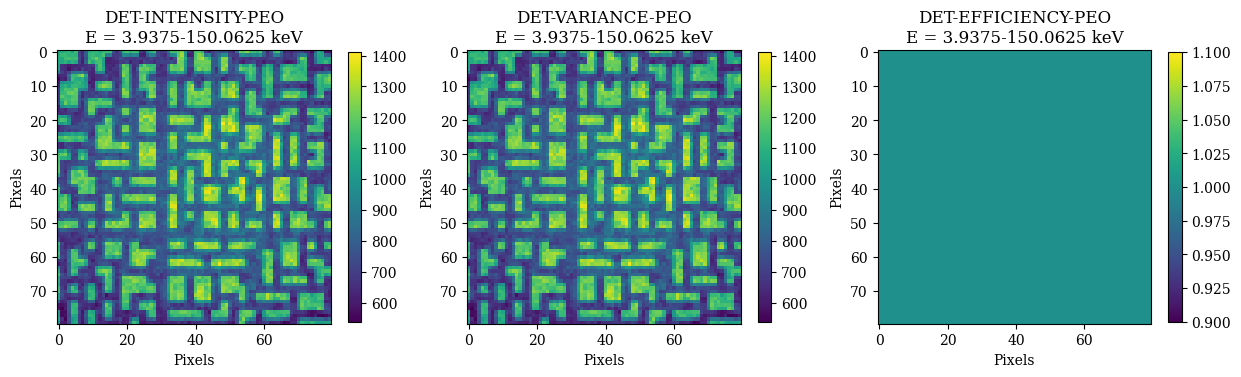

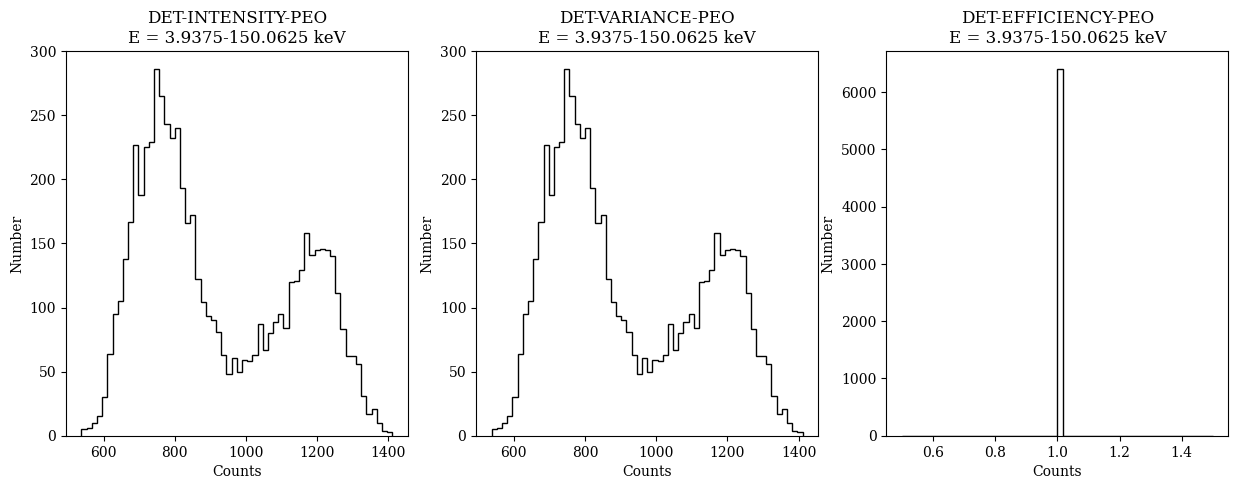

ECL-DET-UBC


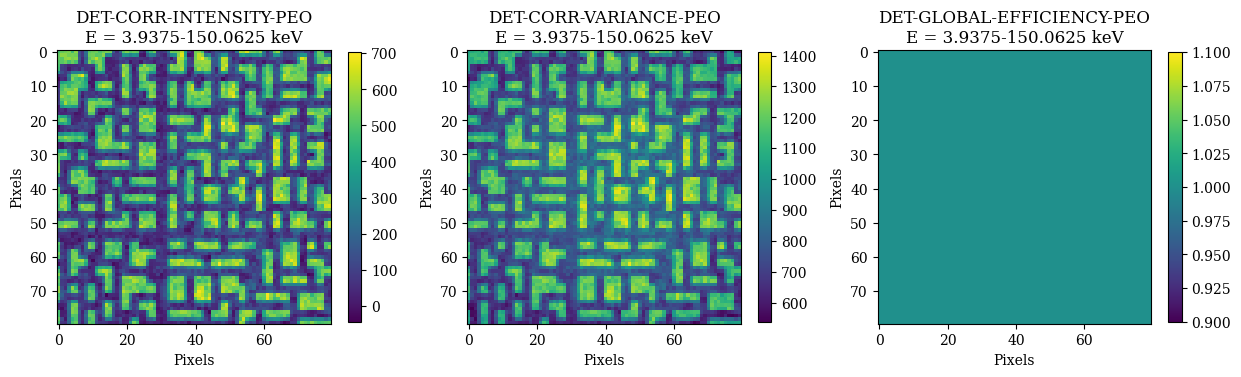

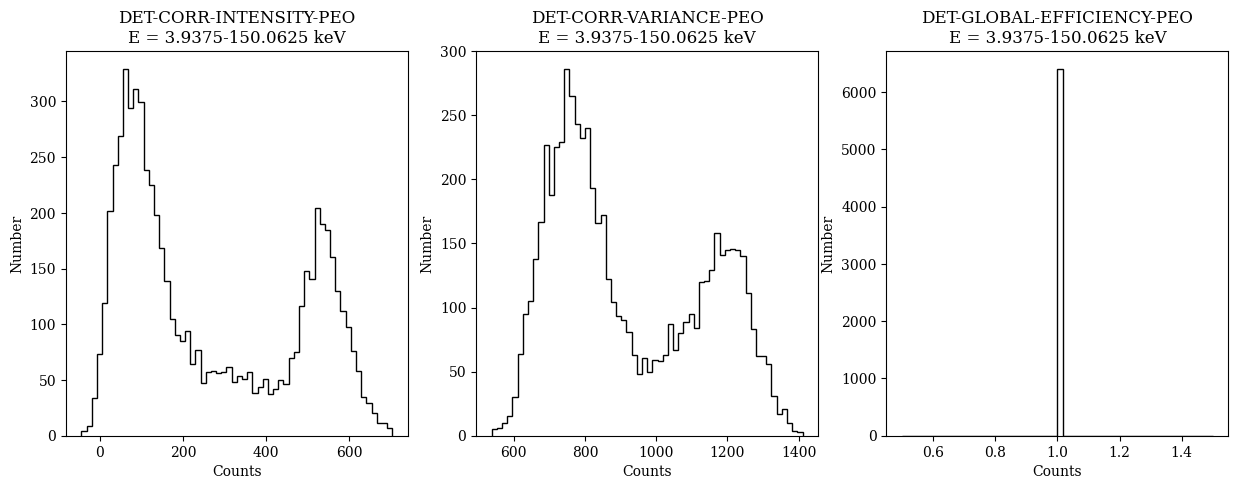

In [33]:
check_det_var(save = 1)

### 2 - Images ciels

Plot les produits ECL-SKY-IMA afin de vérifier qu'il n'y ait pas d'artefacts dans les images.

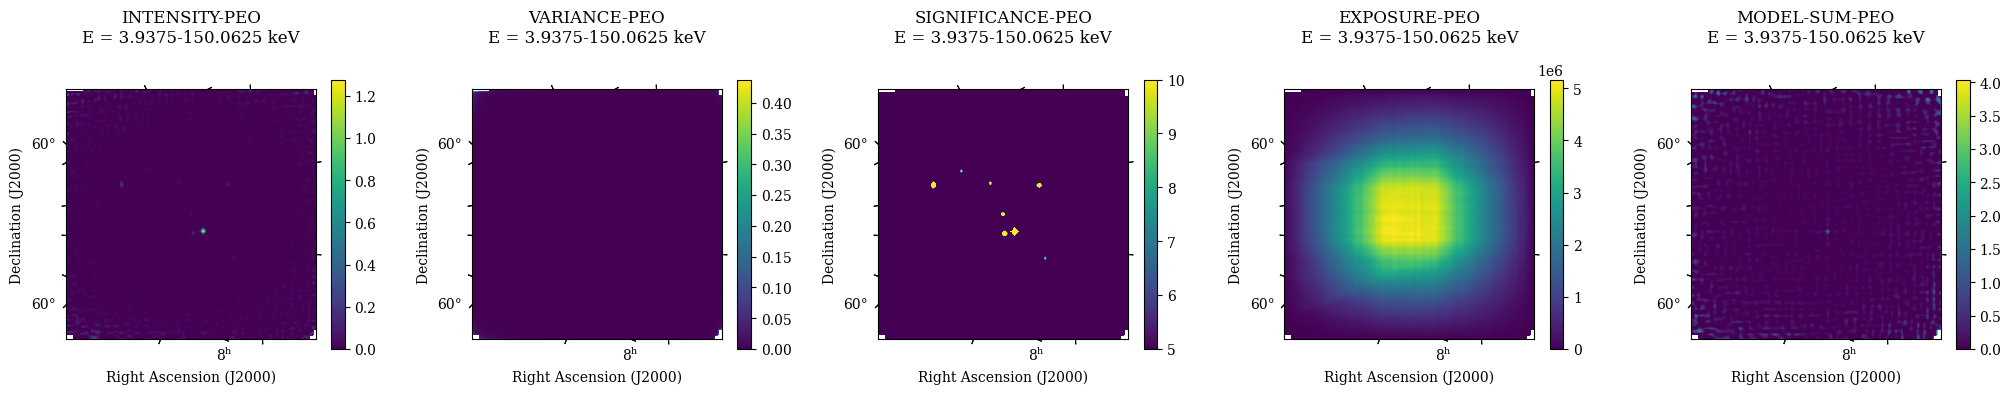

In [34]:
check_sky_file(save = 1)

### 3 - Comparaison flux images ciels et sources 

Plot les sources sur les cartes de significativité et vérifie pour chacune :
> 1) Le pic de flux dans SKY-IMA correspond au flux indiqué dans SOP-IMA.
> 2) Les sources identifiées ont un SNR supérieur au threshold (indiqué par l'utilisateur en tant que paramètre de la fonction).
> 3) Les flux obtenus dans SOP-IMA et SKY-IMA sont compatibles avec le flux attendu.

Le flux attendu est calculé à partir du flux et de l'indice de photon fournis par le catalogue 70 mois de Swift/BAT.

NB : pour 4C +27.14, le flux et l'indice de photon utilisés pour l'estimation du flux attendu sont ceux de Centaurus A.  

8 sources detected in the 3.9375-150.0625 keV energy range
---------- Crab ----------
 Crab has a raw SNR =  505.1766 > 6.5
cos(theta) should be 0.988 at (y_peak, z_peak) position (-9,-13)
Flux  = 2.38615e-08 ergs/cm2/s (14-195 keV)
Gamma = 2.15
Rough expected countrate: 471.348 cts/s
Rough expected countrate in the simulator: 471.348 * 1.37 = 645.746 cts/s
Flux value in SOP-IMA: 1.3224 +/- 0.0026 cts/s/cm2 ; Countrate: 685.553 +/- 1.357 cts/s
Peak value in SKY-IMA: 1.2772 cts/s/cm2 ; Countrate: 662.082 cts/s
Flux in SOP-IMA NOT consistent with expected flux in the simulator
---------- BQ Cam ----------
 BQ Cam has a raw SNR =  54.73198 > 6.5
cos(theta) should be 0.868 at (y_peak, z_peak) position (55,23)
Flux  = 3.424e-10 ergs/cm2/s (14-195 keV)
Gamma = 3.86
Rough expected countrate: 80.026 cts/s
Rough expected countrate in the simulator: 80.026 * 1.37 = 109.636 cts/s
Flux value in SOP-IMA: 0.2137 +/- 0.0039 cts/s/cm2 ; Countrate: 110.806 +/- 2.025 cts/s
Peak value in SKY-IMA: 0.2089 

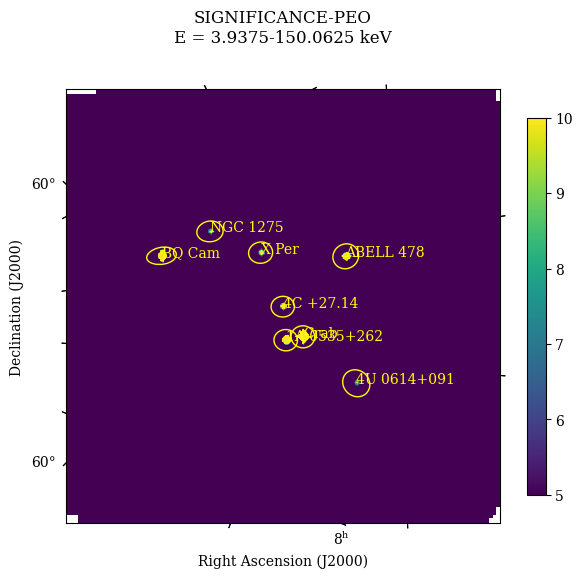

In [35]:
check_peak_flux(threshold = 6.5, save = 1)

### 4 - Cartes OFMs

Plot les OFM.

['Tests_pass1_band_tot/ECL-EAR-OFM-PEO_UTC20210130T090600_tests_dc.fits']


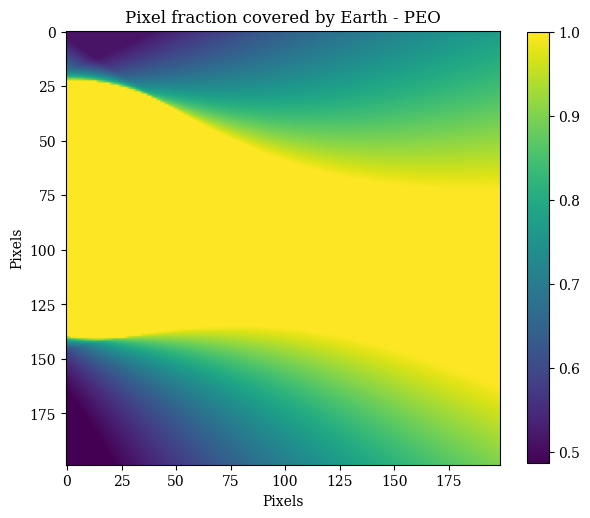

In [36]:
read_EAR_OFM(save = 1)

### 5 - Offset des sources

Permet de tracer l'offset (différence entre position détectée et position catalogue) des sources en fonction du SNR brut et de les comparer par rapport à la relation attendue.

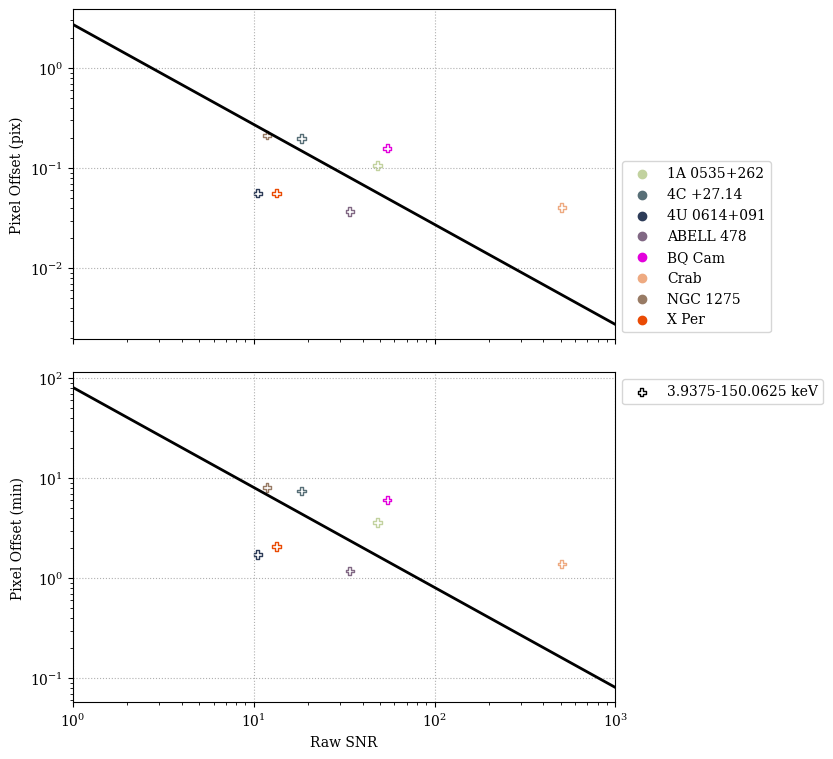

In [37]:
check_offset_vs_snr(save = 1)

### 6 - Positions des sources inconnues

Plot les positions des sources inconnues pour les différentes bandes d'énergie.

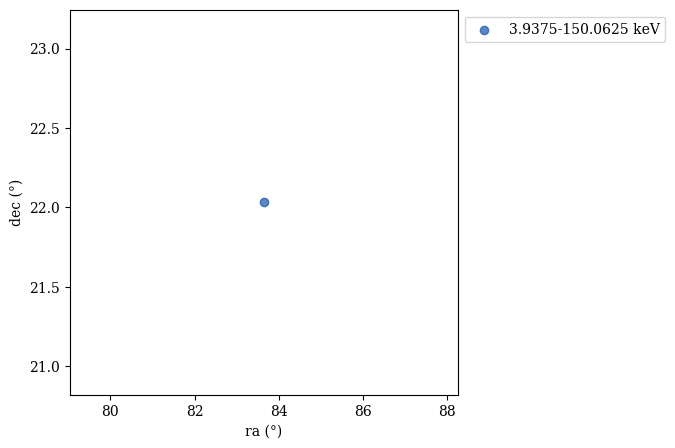

In [38]:
plot_unknown_positions(save = 1)

# Tests spectres

### 1 - Vérification positions

Dans SPS-SOE, compare les positions catalogue des sources (```RA_OBJ```, ```DEC_OBJ```) avec les positions (```RA_POS```, ```DEC_POS```).

In [39]:
check_sps_positions()

----- Crab -----
 RA_OBJ = RA_POS =  74.98951629561985
 DEC_OBJ = DEC_POS =  27.09478155698033
----- BQ Cam -----
 RA_OBJ = RA_POS =  74.98951629561985
 DEC_OBJ = DEC_POS =  27.09478155698033
----- 1A 0535+262 -----
 RA_OBJ = RA_POS =  74.98951629561985
 DEC_OBJ = DEC_POS =  27.09478155698033
----- ABELL 478 -----
 RA_OBJ = RA_POS =  74.98951629561985
 DEC_OBJ = DEC_POS =  27.09478155698033
----- 4C +27.14 -----
 RA_OBJ = RA_POS =  74.98951629561985
 DEC_OBJ = DEC_POS =  27.09478155698033
----- X Per -----
 RA_OBJ = RA_POS =  74.98951629561985
 DEC_OBJ = DEC_POS =  27.09478155698033
----- NGC 1275 -----
 RA_OBJ = RA_POS =  74.98951629561985
 DEC_OBJ = DEC_POS =  27.09478155698033


### 2 - Vérification des shadowgrams

Trace les modèles de shadowgrams pour chaque position de source de SOP-IMA.

------ Energy band : 3.9375 - 150.0625 ------
Shadowgram expected for Crab


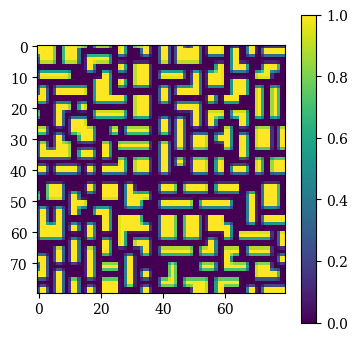

Shadowgram expected for BQ Cam


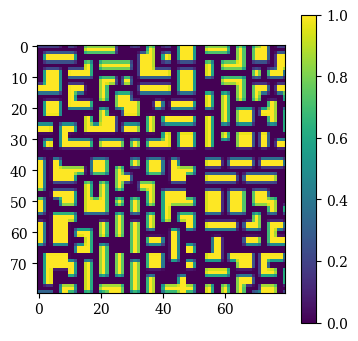

Shadowgram expected for 1A 0535+262


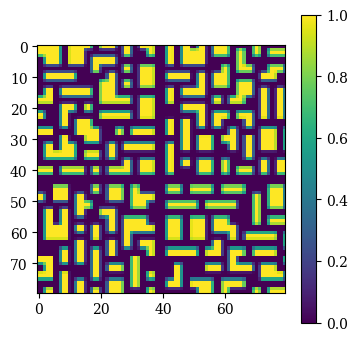

Shadowgram expected for ABELL 478


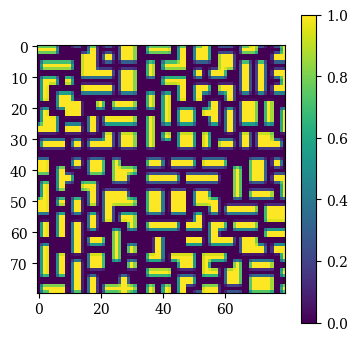

Shadowgram expected for 4C +27.14


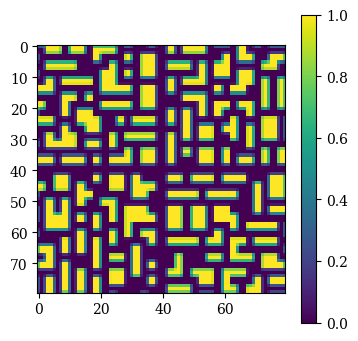

Shadowgram expected for X Per


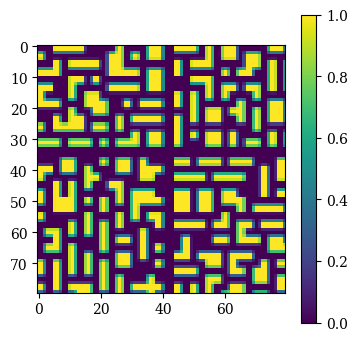

Shadowgram expected for NGC 1275


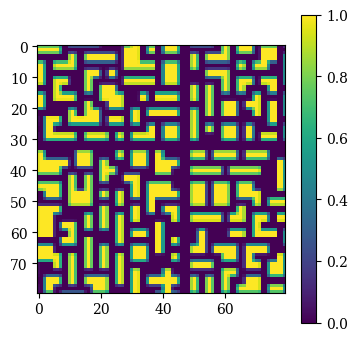

Shadowgram expected for 4U 0614+091


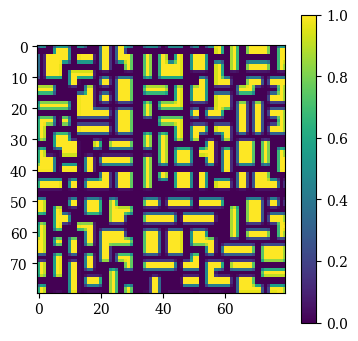

In [40]:
check_shadowgrams()

### 3 - Ajustement de spectre

Crée un fichier .pha ainsi que la rmf rebinnée pour une source choisie par l'utilisateur à partir du produit SPS-SOE. La fonction utilise ensuite xspec pour faire un ajustement par une powerlaw.

NB : afin d'être en accord avec l'input de simulation, la matrice de réponse (fichier rmf) est pour le moment une matrice diagonale et pas la vraie matrice de réponse.

Tests_pass1_15bands/*SPS*PEO*
['Tests_pass1_15bands/ECL-SPS-SOE-PEO_UTC20210130T090600_tests_dc.fits']
results_pass1_15bands/PEO/Crab_PEO.pha has been created!

Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: results_pass1_15bands/PEO/Crab_PEO.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.982e+02 +/- 1.291e+00
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-15
  Telescope: SVOM Instrument: ECL  Channel Type: PI
  Exposure Time: 1788 sec
 Using fit statistic: chi
 Using Response (RMF) File            results_pass1_15bands/PEO/Crab_PEO_rmf.fits for Source 1
 Using Auxiliary Response (ARF) File  ECL-RSP-ARF_20220515T01.fits


Fit statistic  : Chi-Squared                   15.60     using 15 bins.

Test statistic : Chi-Squared                   15.60     using 15 bins.
 Null hypothesis probability of 2.71e-01 with 13 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Para

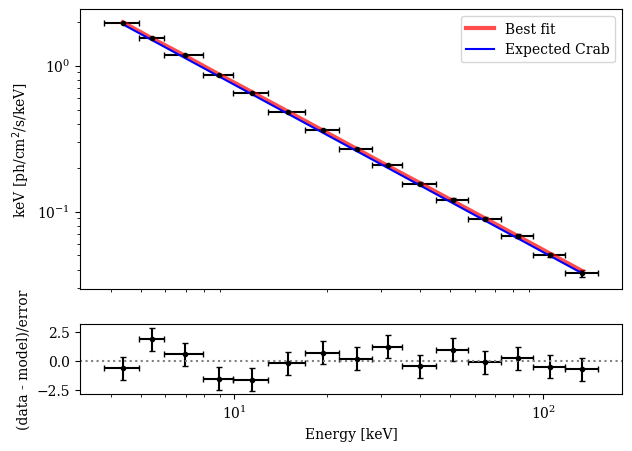

In [25]:
fit_with_xspec("Crab", save = 1)

# Keywords vides

Parcourt tous les fichiers produits et vérifie quels sont les keywords vides/manquants. Les résultats sont stockés dans le répertoire ```output_directory/empty_keywords```.

In [26]:
check_empty_kw()

------------- HDU  0 -------------
GLDM_VER 	 ----------> is empty
TASKNAME 	 ----------> is empty
CALDBVER 	 ----------> is empty
EXTREL 	 ----------> is empty
OBSBOUND 	 ----------> is empty
RA_SAT 	 ----------> is empty
DEC_SAT 	 ----------> is empty
ROLL_SAT 	 ----------> is empty
TELAPSE 	 ----------> is empty
HDUVERS 	 ----------> is empty
DEADC 	 ----------> is empty
EARTH_FR 	 ----------> is empty
EARTHMIN 	 ----------> is empty
EARTHMAX 	 ----------> is empty
BKG_METH 	 ----------> is empty
OFFCOR 	 ----------> is empty
BKG_MAP 	 ----------> is empty
STAMP 	 ----------> is empty
COMMENT is missing
HISTORY is missing
Empty keywords : 18
------------- HDU  1 -------------
GLDM_VER 	 ----------> is empty
TASKNAME 	 ----------> is empty
CALDBVER 	 ----------> is empty
EXTREL 	 ----------> is empty
OBSBOUND 	 ----------> is empty
RA_SAT 	 ----------> is empty
DEC_SAT 	 ----------> is empty
ROLL_SAT 	 ----------> is empty
TELAPSE 	 ----------> is empty
HDUVERS 	 ----------> is empty